In [1]:
from util import *
%load_ext autoreload
# # from ggplot import *
%autoreload 2

Using TensorFlow backend.


In [47]:
def process_batch(file, save_db=False):
    
    batch = pd.read_pickle(file)
    
    result_lst = []
    for idx, group_by_item_id in batch.groupby('ITEM_ID'):
        tmp = list(group_by_item_id.groupby('STOCK_ID'))[0][1]    
        result_lst.append(get_feature_engineered_bundle(tmp))


    results = [result for result in result_lst if result != None]
    result_df = pd.DataFrame(results)
    
    # save feature engineered df
    result_df.to_pickle('data/pickle/ivt_item_feature_engineered/%s' % str(file.split('/')[-1]))
    
    # filter dataframe
    filtered_df = get_filtered_fg_df(result_df)

    
    cleaned_item_ids = filtered_df.item_id.values
    cleaned_df = batch[batch['ITEM_ID'].isin(cleaned_item_ids)]
    
    
    
    df_lst =[]
    
#     save images
    save_img(cleaned_df)

    if save_db:

        for idx, group in cleaned_df.groupby('ITEM_ID'):
            try:
                df_lst.append(get_sell_amount_by_item_id(group))

            except:
                continue


        if len(df_lst) > 0:

            result = pd.concat(df_lst)
            result[['COLLECT_DAY']] = result.index

            del result['STOCK_AMOUNT_imputed']
            del result['STOCK_AMOUNT']

            result.to_sql(con=engine2, name='MWS_COLT_ITEM_SELL_AMT', if_exists='append', flavor='mysql')

            logging.warning('done with %s' % str(file))



In [55]:
def save_img(cleaned_df, label):

    for idx, group in cleaned_df.groupby('STOCK_ID'):
        fig = plt.figure(figsize=(2, 1))
        plt.axis('off')
        plt.plot(group.index, group.STOCK_AMOUNT, '.')
        if label == 'dirty':
            
            plt.savefig('images/dataset/dirty/%s' % idx)
        elif label == 'clean':
            pass
        elif label == 'static':
            plt.savefig('images/dataset/static/%s' % idx)
        plt.close(fig)

In [2]:
feature_engineered_files = glob.glob("data/pickle/ivt_item_feature_engineered/*.pkl")

In [5]:
file = feature_engineered_files[0]

In [18]:
ivt_item_fe_df = pd.read_pickle(file)
filename = file.split('/')[-1]
ivt_item_df = pd.read_pickle(glob.glob("data/pickle/ivt_item/%s" % filename)[0])

In [19]:
feature_engineered_df = ivt_item_fe_df

In [20]:
item_ids_static = feature_engineered_df.item_id[(feature_engineered_df.std_in_cluster == 0.0)].values
data_df_cleaned = feature_engineered_df[feature_engineered_df.mean_in_cluster.notnull()]
purified_df = data_df_cleaned[(data_df_cleaned.ratio_drop < 0.2)
                      & (data_df_cleaned.ratio_same_value < 0.3)
                      & (data_df_cleaned.n_jumps < 2)
                      & (data_df_cleaned.n_days > 20)
                      & (data_df_cleaned.std_in_cluster > 0.2)
                      & (data_df_cleaned.std_in_cluster < 4)
                      & (data_df_cleaned.ratio_of_na < 0.5)
                      & (data_df_cleaned.n_unique_stock_id < 10)]

In [31]:
item_ids = feature_engineered_df.item_id.values
data_dict = {ITEM_ID: df  for ITEM_ID, df in ivt_item_df.groupby('ITEM_ID')}

In [39]:
static_ids = item_ids_static
clean_ids = purified_df.item_id
dirty_ids = np.setdiff1d(np.setdiff1d(item_ids, static_ids), clean_ids)

In [56]:
for static_id in static_ids:
    
    save_img(data_dict[static_id], 'static')
    


In [57]:
for dirty_id in dirty_ids:
    
    save_img(data_dict[dirty_id], 'dirty')
    

In [50]:
files = glob.glob("data/pickle/ivt_item/*.pkl")

In [195]:
file = files[0]

In [203]:
batch = pd.read_pickle(file)[['ID', 'ITEM_ID', 'STOCK_ID', 'STOCK_AMOUNT', 'REG_DT']]
# batch = batch.set_index('REG_DT')


In [185]:
# tmp_lst = list(batch.groupby(['ITEM_ID', 'STOCK_ID']))
_, group = tmp_lst[11]
group[['STOCK_AMOUNT']].resample('1D').first()

,STOCK_AMOUNT
REG_DT,
2017-11-04,3.0
2017-11-05,NaN
2017-11-06,NaN
2017-11-07,NaN
2017-11-08,NaN
...,...
2018-02-03,NaN
2018-02-04,NaN
2018-02-05,NaN


In [205]:
result_lst = []
for _, group in list(batch.groupby(['ITEM_ID', 'STOCK_ID'])):
    result_lst.append(get_feature_engineered_bundle(group))


In [206]:
results = [result for result in result_lst if result != None]
result_df = pd.DataFrame(results)
static_ids, filtered_df = get_filtered_fg_df2(result_df)
batch['Y'] = batch.STOCK_ID.isin(filtered_df.stock_id)
batch.loc[batch.STOCK_ID.isin(static_ids), 'Y'] = 'static'

KeyboardInterrupt: 

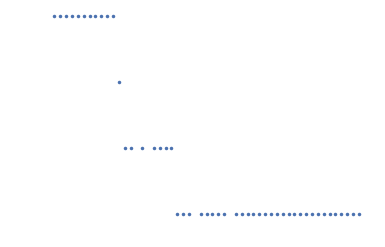

In [209]:


# results = [result for result in result_lst if result != None]
# result_df = pd.DataFrame(results)
# static_ids, filtered_df = get_filtered_fg_df2(result_df)
# batch['Y'] = batch.STOCK_ID.isin(filtered_df.stock_id)
# batch.loc[batch.STOCK_ID.isin(static_ids), 'Y'] = 'static'
# result_df.to_pickle('data/pickle/ivt_item_feature_engineered/%s' % str(file.split('/')[-1]))



# for stock_id, df in batch.groupby('STOCK_ID'):

for idx, group in list(batch.groupby(['ITEM_ID', 'STOCK_ID'])):
    group = group.set_index('REG_DT')
    df = group[['STOCK_AMOUNT', 'Y']].resample('1D').first()

    fig = plt.figure()
    plt.plot(df.index, df.STOCK_AMOUNT, '.')
    plt.axis('off')

    if df.Y[0] == True:
        plt.savefig('images/dataset/correct/%s' % idx[1])
    elif df.Y[0] == 'static':
        plt.savefig('images/dataset/incorrect_static/%s' % idx[1])
    else:
        plt.savefig('images/dataset/incorrect/%s' % idx[1])
    plt.close(fig)

In [178]:
batch = pd.read_pickle(file)
# batch = batch.set_index('REG_DT')
result_lst = []
for idx, group_by_item_id in batch.groupby('ITEM_ID'):
    tmp = list(group_by_item_id.groupby('STOCK_ID'))[0][1]    
    result_lst.append(get_feature_engineered_bundle(tmp))


results = [result for result in result_lst if result != None]
result_df = pd.DataFrame(results)

# filter dataframe
filtered_df = get_filtered_fg_df(result_df)

cleaned_item_ids = filtered_df.item_id.values
cleaned_df = batch[batch['ITEM_ID'].isin(cleaned_item_ids)]
df_lst =[]

In [179]:
cleaned_df = cleaned_df.set_index('REG_DT')


In [180]:
cleaned_df

,ID,ITEM_ID,STOCK_ID,COLOR_OPTION,SIZE_OPTION,STYLE_OPTION,GIFT_OPTION,OPTION,STOCK_AMOUNT,ADD_PRICE,COLLECT_DAY,REG_ID
REG_DT,,,,,,,,,,,,
2017-11-04 15:03:49,1482210203,5621257,-5303229960599649138,노란색,095,None,None,,18,0,20171104,SERVER
2017-11-04 15:03:49,1482210204,5621257,-5303229960599585407,노란색,100,None,None,,26,0,20171104,SERVER
2017-11-04 15:03:49,1482210205,5621257,-5303229960599585402,노란색,105,None,None,,14,0,20171104,SERVER
2017-11-04 15:03:49,1482210206,5621257,-5303229960599585150,노란색,110,None,None,,7,0,20171104,SERVER
2017-11-05 17:51:16,1500768962,5621257,-5303229960599649138,노란색,095,None,None,,18,0,20171105,SERVER
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-21 21:03:33,2654485836,5621257,-5303229960599585150,노란색,110,None,None,,5,0,20180121,SERVER
2018-01-22 21:13:23,2670023342,5621257,-5303229960599649138,노란색,095,None,None,,10,0,20180122,SERVER
2018-01-22 21:13:23,2670023343,5621257,-5303229960599585407,노란색,100,None,None,,12,0,20180122,SERVER


In [152]:
# filtered_df[~filtered_df.stock_id.isin(static_ids)]

,item_id,max_consecutive_na,max_drop,max_v,mean_in_cluster,median_v,min_v,n_cluster,n_consecutive_na,n_days,n_jumps,n_unique_stock_id,range_v,ratio_drop,ratio_of_na,ratio_same_value,std_in_cluster,std_v,stock_id
263,5621272,10,1.0,7.0,6.142857,6.0,5.0,1,14,80,1,1,2.0,0.142857,0.387500,0.212500,1.505093,0.709899,-2826405963195130335
686,5621257,10,1.0,7.0,7.416667,6.0,5.0,1,13,80,1,1,2.0,0.142857,0.375000,0.262500,0.759203,0.721110,-5303229960599585150
687,5621257,10,2.0,14.0,2.500000,10.0,6.0,3,13,80,0,1,8.0,0.142857,0.375000,0.175000,2.929733,2.336151,-5303229960599585402
1561,5621794,2,2.0,99.0,1.090909,86.0,74.0,2,6,76,1,1,25.0,0.020202,0.092105,0.131579,0.287480,7.157865,2658512032668233991
3643,5621358,15,4.0,29.0,1.800000,16.0,15.0,6,10,66,0,1,14.0,0.137931,0.469697,0.212121,0.979796,4.445039,9115921938306212716


In [138]:
batch.loc[batch.STOCK_ID.isin(static_ids), 'Y'] = 'static'

In [139]:
batch.loc[batch.STOCK_ID.isin(static_ids), 'Y'] = 'static'

,ID,ITEM_ID,STOCK_ID,STOCK_AMOUNT,Y
REG_DT,,,,,
2017-11-04 14:45:43,1482089358,5621097,28256818001,5,static
2017-11-04 14:45:43,1482089359,5621097,28256818002,5,static
2017-11-04 14:45:43,1482089360,5621097,28256818003,5,static
2017-11-10 16:02:44,1582523490,5621097,28256818001,5,static
2017-11-10 16:02:44,1582523498,5621097,28256818002,5,static
...,...,...,...,...,...
2017-11-06 16:52:39,1516858662,5622095,-3748915529047864559,2,False
2017-11-06 16:52:39,1516858663,5622095,-1474635995056993671,2,False
2017-11-06 16:52:39,1516858664,5622095,-3748914407892971245,2,False


In [137]:
len(batch)

178620

In [135]:
sum(batch.STOCK_ID.isin(static_ids))

54119

In [103]:
tmp_lst = list(batch.groupby('STOCK_ID'))

In [106]:
stock_id, df = tmp_lst[0]

In [123]:

fig = plt.figure()
plt.plot(df.index, df.STOCK_AMOUNT, '.')
plt.axis('off')

if not df.Y[0]:
    plt.savefig('images/dataset/correct/%s' % stock_id)
else:
    plt.savefig('images/dataset/incorrect/%s' % stock_id)
plt.close(fig)
    

In [100]:
batch[(batch.STOCK_ID == '28256818001') & (batch.Y == False)]

,ID,ITEM_ID,STOCK_ID,STOCK_AMOUNT,Y
REG_DT,,,,,
2017-11-04 14:45:43,1482089358,5621097,28256818001,5,False
2017-11-10 16:02:44,1582523490,5621097,28256818001,5,False
2017-11-17 12:16:22,1690619292,5621097,28256818001,5,False


In [95]:
 batch.Y

REG_DT
2017-11-04 14:45:43    False
2017-11-04 14:45:43    False
2017-11-04 14:45:43    False
2017-11-10 16:02:44    False
2017-11-10 16:02:44    False
                       ...  
2017-11-06 16:52:39    False
2017-11-06 16:52:39    False
2017-11-06 16:52:39    False
2017-11-06 16:52:39    False
2017-11-06 16:52:39    False
Name: Y, dtype: bool

In [2]:
files.sort()

NameError: name 'files' is not defined

In [4]:
files.sort()
file_lst = []

# for file in files:
#     file_lst.append(pd.read_pickle(file))
    
def read_file(file):
    logging.warn(file)
    return pd.read_pickle(file)[['ITEM_ID', 'STOCK_ID', 'STOCK_AMOUNT', 'REG_DT']]
file_lst = Parallel(n_jobs=-1)(map(delayed(read_file), files))    
    
# pd.concat([batch0, batch1])

In [6]:
merged_df = pd.concat(file_lst)

In [8]:
merged_df = merged_df.set_index('REG_DT')

In [ ]:
group_list = list(merged_df.groupby('STOCK_ID'))